<a href="https://colab.research.google.com/github/AntonDozhdikov/politpredict/blob/main/20_political_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для предотвращения отключения среды введите '555' и нажмите Enter:
Среда защищена от отключения.

ЗАПУСК MADDPG ЭКСПЕРИМЕНТА (30 ЭПОХ)
Запуск эксперимента с MADDPG агентами...
Загрузка реальных исторических данных...
Загрузка данных для United States...
Загрузка данных для China...
Загрузка данных для Japan...
Загрузка данных для Germany...
Загрузка данных для India...
Загрузка данных для United Kingdom...
Загрузка данных для France...
Загрузка данных для Italy...
Загрузка данных для Brazil...
Загрузка данных для Canada...
Загрузка данных для South Korea...
Загрузка данных для Russia...
Загрузка данных для Australia...
Загрузка данных для Spain...
Загрузка данных для Mexico...
Загрузка данных для Indonesia...
Загрузка данных для Netherlands...
Загрузка данных для Saudi Arabia...
Загрузка данных для Turkey...
Загрузка данных для Switzerland...
Реальные данные успешно загружены.
Генерация синтетических данных...
Синтетические данные сгенерированы.
Эпизод 1/30
  Шаг 60/600 (10.0%) | Прошл

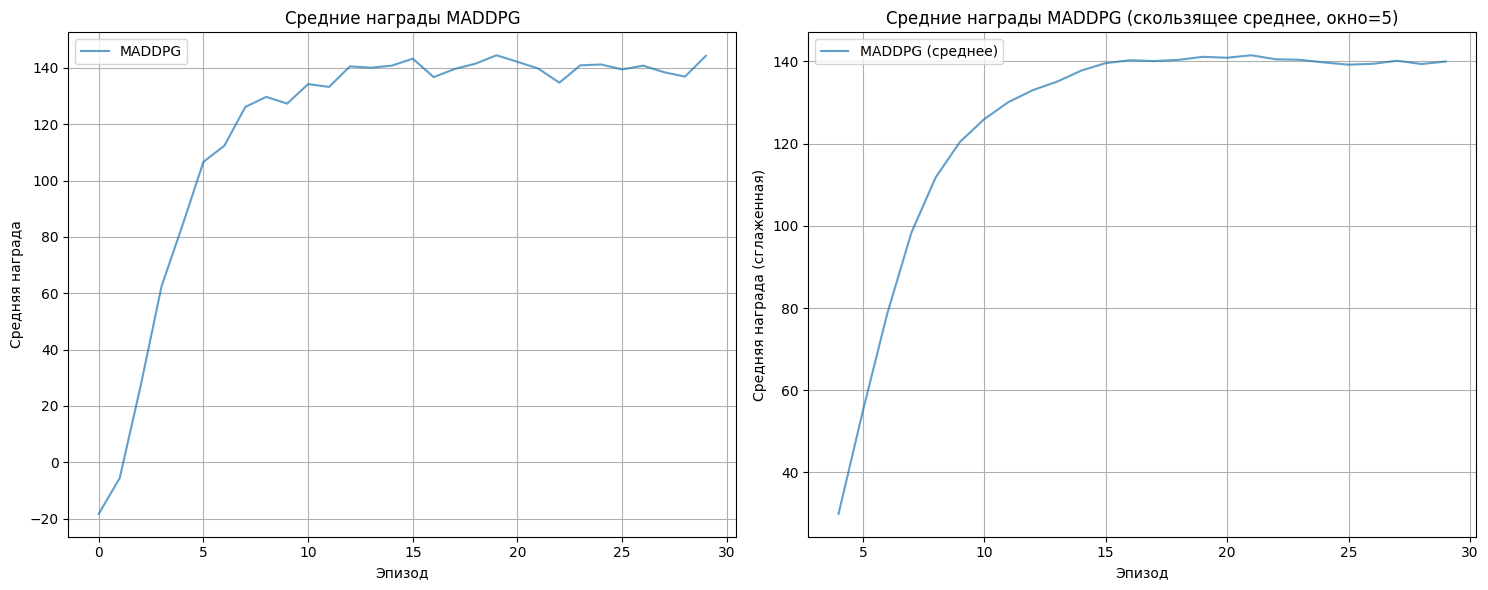


=== ИТОГОВАЯ СВОДКА ДЛЯ MADDPG ===
Средняя награда по всем эпизодам: 118.16
Общее количество кризисов: 13276
Общее количество переходов между стадиями: 1025

Топ-5 типов кризисов по частоте:
  Военный конфликт: 1694 раз
  Экологическая катастрофа: 1680 раз
  Экономический кризис: 1679 раз
  Финансовый крах: 1665 раз
  Политический переворот: 1645 раз


In [1]:
# =============================================================================
# БЛОК 1: ЭКСПЕРИМЕНТ С MADDPG (30 ЭПОХ)
# =============================================================================

import time
import random
import numpy as np
import pandas as pd
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
import json
import requests
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import torch.multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter

CONFIG = {
    'start_year': 2017,
    'train_end_year': 2024,
    'sim_start_year': 2025,
    'sim_end_year': 2075,
    'steps_per_year': 12,
    'num_episodes': 30,  # Изменено на 30
    'top_countries': 20,
    'observation_total_size': 12,
    'observation_in_size': 12,
    'action_size': 45,
    'hidden_dim': 256,
    'lr_actor': 1e-4,
    'lr_critic': 1e-3,
    'gamma': 0.99,
    'tau': 0.01,
    'buffer_size': int(1e6),
    'batch_size': 256,
    'update_every': 10,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,
    'clip_epsilon': 0.2,
    'gae_lambda': 0.95,
    'ppo_epochs': 4,
    'entropy_coef': 0.01,
    'max_grad_norm': 0.5,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_dir': 'experiment_results_maddpg',
    'data_dir': 'data'
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['data_dir'], exist_ok=True)

def fetch_world_bank_data(indicator, country_code, start_year, end_year):
    base_url = "http://api.worldbank.org/v2/country"
    url = f"{base_url}/{country_code}/indicator/{indicator}?date={start_year}:{end_year}&format=json&per_page=100"

    try:
        response = requests.get(url)
        data = response.json()
        if len(data) > 1:
            return {item['date']: item['value'] for item in data[1] if item['value'] is not None}
        else:
            return {}
    except Exception as e:
        print(f"Ошибка при загрузке данных для {country_code}, {indicator}: {e}")
        return {}

def load_real_historical_data():
    print("Загрузка реальных исторических данных...")

    countries = {
        "United States": "US", "China": "CN", "Japan": "JP", "Germany": "DE", "India": "IN",
        "United Kingdom": "GB", "France": "FR", "Italy": "IT", "Brazil": "BR", "Canada": "CA",
        "South Korea": "KR", "Russia": "RU", "Australia": "AU", "Spain": "ES", "Mexico": "MX",
        "Indonesia": "ID", "Netherlands": "NL", "Saudi Arabia": "SA", "Turkey": "TR", "Switzerland": "CH"
    }

    indicators = {
        'gdp_growth': 'NY.GDP.MKTP.KD.ZG', 'unemployment': 'SL.UEM.TOTL.ZS', 'inflation': 'FP.CPI.TOTL.ZG',
        'aging_index': 'SP.POP.65UP.TO.ZS', 'migration_net': 'SM.POP.NETM', 'gini_coefficient': 'SI.POV.GINI',
        'corruption_index': 'CC.EST', 'political_stability': 'PV.EST', 'innovation_index': 'GB.XPD.RSDV.GD.ZS',
        'environmental_footprint': 'EN.ATM.CO2E.PC', 'education_index': 'SE.TER.ENRR', 'press_freedom': 'EN.PUB.FREX'
    }

    data = {}

    for country_name, country_code in countries.items():
        print(f"Загрузка данных для {country_name}...")
        country_data = {}

        for indicator_name, indicator_code in indicators.items():
            indicator_data = fetch_world_bank_data(indicator_code, country_code, CONFIG['start_year'], CONFIG['train_end_year'])
            country_data[indicator_name] = indicator_data

        years = list(range(CONFIG['start_year'], CONFIG['train_end_year'] + 1))
        country_array = []

        for year in years:
            year_str = str(year)
            row = []
            for indicator_name in indicators.keys():
                value = country_data[indicator_name].get(year_str, np.nan)
                row.append(value if value is not None else np.nan)
            country_array.append(row)

        country_array = np.array(country_array)
        if len(country_array) > 0:
            df = pd.DataFrame(country_array, columns=list(indicators.keys()))
            df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
            data[country_name] = df.values
        else:
            data[country_name] = np.zeros((CONFIG['train_end_year'] - CONFIG['start_year'] + 1, len(indicators)))

    print("Реальные данные успешно загружены.")
    return data, list(countries.keys())

def generate_synthetic_data(historical_data, countries):
    print("Генерация синтетических данных...")
    synthetic_data = {}

    for country in countries:
        if country in historical_data and len(historical_data[country]) > 0:
            last_data = historical_data[country][-1]
        else:
            last_data = np.random.randn(CONFIG['observation_total_size']) * 0.1

        sim_years = CONFIG['sim_end_year'] - CONFIG['sim_start_year'] + 1
        country_data = []

        for _ in range(sim_years):
            noise = np.random.randn(len(last_data)) * 0.01
            new_data = last_data + noise
            country_data.append(new_data)
            last_data = new_data

        synthetic_data[country] = np.array(country_data)

    print("Синтетические данные сгенерированы.")
    return synthetic_data

def load_historical_data():
    try:
        real_data, countries = load_real_historical_data()
    except Exception as e:
        print(f"Не удалось загрузить реальные данные: {e}")
        print("Использование синтетических данных...")
        countries = [
            "United States", "China", "Japan", "Germany", "India", "United Kingdom",
            "France", "Italy", "Brazil", "Canada", "South Korea", "Russia", "Australia",
            "Spain", "Mexico", "Indonesia", "Netherlands", "Saudi Arabia", "Turkey", "Switzerland"
        ]

        np.random.seed(42)
        real_data = {}

        for country in countries:
            years = CONFIG['train_end_year'] - CONFIG['start_year'] + 1
            country_data = np.random.randn(years, CONFIG['observation_total_size']) * 0.1
            real_data[country] = country_data

    synthetic_data = generate_synthetic_data(real_data, countries)
    return real_data, synthetic_data, countries

class CountrySystem:
    def __init__(self, name, initial_state):
        self.name = name
        self.state = initial_state.copy()
        self.internal_state = self._initialize_internal_state()
        self.stage = "I. Конструктивная адаптация"
        self.history = []
        self.crisis_history = []
        self.stage_transitions = []
        self.step_count = 0
        self.year = CONFIG['sim_start_year']
        self.month = 1

    def _initialize_internal_state(self):
        return np.array([
            0.8, 1.0, 0.7, 0.75, 0.6, 0.5, 0.2, 0.8, 0.3, 0.5, 0.7, 0.6
        ])

    def get_observation_total(self):
        return self.state

    def get_observation_in(self):
        return self.internal_state

    def apply_action(self, action):
        reward = 0
        crisis_event = None

        self._update_internal_state(action)
        self._update_external_state(action)

        crisis_event = self._check_for_crisis()
        if crisis_event:
            self.crisis_history.append({
                'step': self.step_count, 'year': self.year, 'month': self.month, 'crisis': crisis_event
            })
            reward -= 100

        new_stage = self._check_stage_transition()
        if new_stage != self.stage:
            self.stage_transitions.append({
                'step': self.step_count, 'year': self.year, 'month': self.month,
                'from_stage': self.stage, 'to_stage': new_stage
            })
            self.stage = new_stage
            reward += self._get_stage_reward(new_stage)

        reward += self._calculate_stability_reward()

        self.step_count += 1
        self.month += 1
        if self.month > 12:
            self.month = 1
            self.year += 1

        self.history.append({
            'step': self.step_count, 'state': self.state.copy(), 'internal_state': self.internal_state.copy(),
            'stage': self.stage, 'year': self.year, 'month': self.month
        })

        return reward, crisis_event is not None

    def _update_internal_state(self, action):
        action_effects = np.zeros_like(self.internal_state)

        if action == 0:  # Повышение налогов
            action_effects[0] -= 0.03; action_effects[2] -= 0.01; action_effects[9] -= 0.02
        elif action == 1:  # Снижение налогов
            action_effects[0] += 0.02; action_effects[2] += 0.01; action_effects[9] += 0.03
        elif action == 2:  # Увеличение социальных расходов
            action_effects[4] += 0.04; action_effects[10] += 0.03; action_effects[9] += 0.02
        elif action == 3:  # Сокращение социальных расходов
            action_effects[4] -= 0.03; action_effects[10] -= 0.02; action_effects[9] -= 0.01
        elif action == 4:  # Реформа пенсионной системы
            action_effects[4] += 0.02; action_effects[1] += 0.03
        elif action == 5:  # Реформа здравоохранения
            action_effects[0] += 0.02; action_effects[10] += 0.02
        elif action == 6:  # Инвестиции в образование и науку
            action_effects[5] += 0.04; action_effects[7] += 0.03
        elif action == 7:  # Поддержка инноваций и стартапов
            action_effects[5] += 0.05; action_effects[11] += 0.04
        elif action == 8:  # Ужесточение миграционной политики
            action_effects[4] -= 0.02; action_effects[10] -= 0.01
        elif action == 9:  # Либерализация миграционной политики
            action_effects[4] += 0.03; action_effects[10] += 0.02
        elif action == 10: # Проведение амнистии для мигрантов
            action_effects[4] += 0.02; action_effects[10] += 0.03
        elif action == 11: # Усиление полицейского контроля
            action_effects[0] -= 0.02; action_effects[9] -= 0.03
        elif action == 12: # Снижение репрессий, декриминализация
            action_effects[0] += 0.03; action_effects[9] += 0.02
        elif action == 13: # Проведение выборов (честных, свободных)
            action_effects[0] += 0.05; action_effects[7] += 0.04
        elif action == 14: # Фальсификация выборов
            action_effects[0] -= 0.04; action_effects[7] -= 0.03
        elif action == 15: # Роспуск парламента
            action_effects[0] -= 0.03; action_effects[8] += 0.04
        elif action == 16: # Распуск оппозиционных партий
            action_effects[0] -= 0.04; action_effects[7] -= 0.03
        elif action == 17: # Преследование оппозиционеров
            action_effects[0] -= 0.03; action_effects[8] += 0.03
        elif action == 18: # Амнистия политзаключенных
            action_effects[0] += 0.02; action_effects[10] += 0.02
        elif action == 19: # Реформа судебной системы
            action_effects[0] += 0.03; action_effects[11] += 0.02
        elif action == 20: # Укрепление независимости судов
            action_effects[0] += 0.04; action_effects[7] += 0.03
        elif action == 21: # Подавление свободы слова
            action_effects[0] -= 0.04; action_effects[7] -= 0.03
        elif action == 22: # Поддержка свободы слова
            action_effects[0] += 0.04; action_effects[7] += 0.03
        elif action == 23: # Введение цензуры
            action_effects[0] -= 0.03; action_effects[8] += 0.03
        elif action == 24: # Поддержка СМИ
            action_effects[0] += 0.03; action_effects[7] += 0.02
        elif action == 25: # Проведение референдума
            action_effects[0] += 0.02; action_effects[7] += 0.02
        elif action == 26: # Реформа конституции
            action_effects[11] += 0.04; action_effects[5] -= 0.02
        elif action == 27: # Увеличение числа чиновников
            action_effects[1] -= 0.02; action_effects[8] += 0.02
        elif action == 28: # Сокращение бюрократии
            action_effects[1] += 0.03; action_effects[11] += 0.02
        elif action == 29: # Борьба с коррупцией (эффективная)
            action_effects[0] += 0.04; action_effects[10] += 0.03
        elif action == 30: # Имитация борьбы с коррупцией
            action_effects[0] -= 0.02; action_effects[10] -= 0.01
        elif action == 31: # Заключение торгового соглашения
            action_effects[3] += 0.02; action_effects[11] += 0.02
        elif action == 32: # Введение торговых пошлин/санкций
            action_effects[3] -= 0.02; action_effects[9] -= 0.02
        elif action == 33: # Поддержка экспорта
            action_effects[3] += 0.03; action_effects[11] += 0.02
        elif action == 34: # Поддержка импорта
            action_effects[3] += 0.02; action_effects[5] -= 0.01
        elif action == 35: # Заключение военного альянса
            action_effects[9] -= 0.03; action_effects[8] += 0.02
        elif action == 36: # Выход из военного альянса
            action_effects[9] += 0.02; action_effects[11] += 0.01
        elif action == 37: # Начало переговоров
            action_effects[0] += 0.02; action_effects[3] += 0.02
        elif action == 38: # Прекращение переговоров
            action_effects[0] -= 0.01; action_effects[3] -= 0.01
        elif action == 39: # Ведение войны (наступательной)
            action_effects[9] -= 0.05; action_effects[8] += 0.04
        elif action == 40: # Ведение войны (оборонительной)
            action_effects[9] -= 0.03; action_effects[10] -= 0.02
        elif action == 41: # Отправка миротворцев
            action_effects[0] += 0.02; action_effects[3] += 0.02
        elif action == 42: # Принятие беженцев
            action_effects[4] += 0.03; action_effects[10] += 0.02
        elif action == 43: # Отказ от беженцев
            action_effects[4] -= 0.02; action_effects[10] -= 0.01
        elif action == 44: # Мирная экспансия
            action_effects[5] += 0.03; action_effects[11] += 0.03

        self.internal_state = np.clip(self.internal_state + action_effects, 0.0, 1.0)

    def _update_external_state(self, action):
        noise = np.random.normal(0, 0.01, len(self.state))
        self.state = self.state + noise

        if action == 0:
            self.state[0] -= 0.1; self.state[1] += 0.2
        elif action == 2:
            self.state[4] += 0.1; self.state[6] -= 0.05
        elif action == 6:
            self.state[8] += 0.03
        elif action == 7:
            self.state[8] += 0.05
        elif action == 39:
            self.state[0] -= 0.3; self.state[1] += 0.5; self.state[2] += 0.3

    def _check_for_crisis(self):
        crisis_probability = 0.0

        if self.internal_state[4] < 0.3 and self.state[5] > 0.7:
            crisis_probability += 0.1
        if self.state[4] > 1.0 and self.internal_state[10] < 0.4:
            crisis_probability += 0.15
        if self.internal_state[0] < 0.3 and self.internal_state[2] < 0.4:
            crisis_probability += 0.2
        if self.state[0] < -2.0 or self.state[1] > 15.0:
            crisis_probability += 0.25

        if np.random.random() < crisis_probability:
            crises = ["Политический переворот", "Экономический кризис", "Социальные волнения",
                     "Военный конфликт", "Экологическая катастрофа", "Финансовый крах",
                     "Пандемия", "Технологическая катастрофа"]
            return np.random.choice(crises)

        return None

    def _check_stage_transition(self):
        if (self.internal_state[0] > 0.8 and self.internal_state[2] > 0.8 and
            self.internal_state[10] > 0.8 and self.internal_state[4] > 0.7):
            return "Точка Превосходства"

        elif (self.internal_state[5] > 0.7 and self.internal_state[7] < 0.3 and
              self.internal_state[1] < 0.4):
            return "Точка Плато (Застой)"

        elif (self.internal_state[6] > 0.8 and self.internal_state[9] < 0.2 and
              self.internal_state[8] > 0.7):
            return "Точка Перенапряжения"

        elif (self.internal_state[10] < 0.2 and self.internal_state[0] < 0.2 and
              self.internal_state[7] < 0.1):
            return "Точка Гибели/Перезапуска"

        if self.internal_state[5] > 0.6 and self.internal_state[7] < 0.4:
            return "III. Деструктивная экспансия"
        elif self.internal_state[5] < 0.4 and self.internal_state[7] > 0.6:
            return "I. Конструктивная адаптация"
        elif self.internal_state[5] > 0.5 and self.internal_state[7] > 0.5:
            return "II. Конструктивная экспансия"
        else:
            return "IV. Деструктивная адаптация (кризис)"

    def _get_stage_reward(self, stage):
        rewards = {
            "Точка Превосходства": 100, "I. Конструктивная адаптация": 50,
            "II. Конструктивная экспансия": 50, "Точка Плато (Застой)": -10,
            "III. Деструктивная экспансия": -50, "Точка Перенапряжения": -100,
            "IV. Деструктивная адаптация (кризис)": -200, "Точка Гибели/Перезапуска": -1000
        }
        return rewards.get(stage, 0)

    def _calculate_stability_reward(self):
        stability_reward = 0
        balance = abs(self.internal_state[5] - 0.5)
        stability_reward += (1 - balance) * 10
        stability_reward += self.internal_state[0] * 5
        stability_reward -= self.internal_state[6] * 10
        stability_reward += self.internal_state[4] * 3
        stability_reward -= self.internal_state[8] * 5
        return stability_reward

class MADDPGActor(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=CONFIG['hidden_dim']):
        super(MADDPGActor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        return self.net(obs)

class MADDPGCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, num_agents, hidden_dim=CONFIG['hidden_dim']):
        super(MADDPGCritic, self).__init__()
        self.num_agents = num_agents
        total_obs_dim = obs_dim * num_agents
        total_action_dim = action_dim * num_agents

        self.net = nn.Sequential(
            nn.Linear(total_obs_dim + total_action_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs, actions):
        obs_flat = torch.cat(obs, dim=-1)
        actions_flat = torch.cat(actions, dim=-1)
        x = torch.cat([obs_flat, actions_flat], dim=-1)
        return self.net(x)

class MADDPGAgent:
    def __init__(self, obs_total_dim, obs_in_dim, action_dim, agent_id, num_agents):
        self.agent_id = agent_id
        self.action_dim = action_dim
        self.obs_total_dim = obs_total_dim
        self.obs_in_dim = obs_in_dim
        self.num_agents = num_agents

        self.actor = MADDPGActor(obs_total_dim + obs_in_dim, action_dim).to(CONFIG['device'])
        self.actor_target = MADDPGActor(obs_total_dim + obs_in_dim, action_dim).to(CONFIG['device'])
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=CONFIG['lr_actor'])

        self.critic = MADDPGCritic(obs_total_dim + obs_in_dim, action_dim, num_agents).to(CONFIG['device'])
        self.critic_target = MADDPGCritic(obs_total_dim + obs_in_dim, action_dim, num_agents).to(CONFIG['device'])
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CONFIG['lr_critic'])

        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)

        self.memory = deque(maxlen=CONFIG['buffer_size'])
        self.epsilon = CONFIG['epsilon_start']
        self.experience = namedtuple("Experience",
                                   field_names=["state", "action", "reward", "next_state", "done"])

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, source, tau=CONFIG['tau']):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def act(self, obs_total, obs_in, noise=True):
        obs = torch.FloatTensor(np.concatenate([obs_total, obs_in])).unsqueeze(0).to(CONFIG['device'])
        action_probs = self.actor(obs)

        if noise and random.random() < self.epsilon:
            action = random.choice(range(self.action_dim))
        else:
            action = torch.argmax(action_probs).item()

        return action

    def remember(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def replay(self, agents):
        if len(self.memory) < CONFIG['batch_size']:
            return

        experiences = random.sample(self.memory, k=CONFIG['batch_size'])

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(CONFIG['device'])
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(CONFIG['device'])
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(CONFIG['device'])
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(CONFIG['device'])
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(CONFIG['device'])

        obs_total_dim = self.obs_total_dim
        obs_in_dim = self.obs_in_dim

        states_list = []
        next_states_list = []
        actions_list = []

        for i in range(self.num_agents):
            start_total = i * (obs_total_dim + obs_in_dim)
            end_total = start_total + obs_total_dim
            start_in = end_total
            end_in = start_in + obs_in_dim

            states_list.append(states[:, start_total:end_in])
            next_states_list.append(next_states[:, start_total:end_in])
            actions_list.append(actions[:, i])

        next_actions = []
        for i, agent in enumerate(agents):
            next_action_probs = agent.actor_target(next_states_list[i])
            next_actions.append(torch.argmax(next_action_probs, dim=-1, keepdim=True))

        next_actions_onehot = [F.one_hot(na.squeeze(-1), num_classes=self.action_dim).float() for na in next_actions]

        Q_targets_next = self.critic_target(next_states_list, next_actions_onehot).squeeze(-1)
        Q_targets = rewards[:, self.agent_id] + (CONFIG['gamma'] * Q_targets_next * (1 - dones[:, self.agent_id]))

        actions_onehot = [F.one_hot(a, num_classes=self.action_dim).float() for a in actions_list]
        Q_expected = self.critic(states_list, actions_onehot).squeeze(-1)

        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), CONFIG['max_grad_norm'])
        self.critic_optimizer.step()

        actions_pred = self.actor(states_list[self.agent_id])
        actions_pred_onehot = F.gumbel_softmax(torch.log(actions_pred + 1e-8), hard=True)

        actor_loss = -self.critic(states_list,
                                 [F.one_hot(a, num_classes=self.action_dim).float() if i != self.agent_id
                                  else actions_pred_onehot for i, a in enumerate(actions_list)]).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), CONFIG['max_grad_norm'])
        self.actor_optimizer.step()

        self.soft_update(self.actor_target, self.actor)
        self.soft_update(self.critic_target, self.critic)

        self.epsilon = max(CONFIG['epsilon_end'], self.epsilon * CONFIG['epsilon_decay'])

def run_maddpg_experiment():
    print("Запуск эксперимента с MADDPG агентами...")

    real_data, synthetic_data, countries = load_historical_data()

    country_systems = {}
    for country in countries:
        if country in real_data and len(real_data[country]) > 0:
            initial_state = real_data[country][-1]
        else:
            initial_state = synthetic_data[country][0] if len(synthetic_data[country]) > 0 else np.zeros(CONFIG['observation_total_size'])
        country_systems[country] = CountrySystem(country, initial_state)

    agents = {}
    obs_total_dim = CONFIG['observation_total_size']
    obs_in_dim = CONFIG['observation_in_size']
    action_dim = CONFIG['action_size']
    num_agents = len(countries)

    for i, country in enumerate(countries):
        agents[country] = MADDPGAgent(obs_total_dim, obs_in_dim, action_dim, i, num_agents)

    all_rewards = []
    all_crisis_histories = {country: [] for country in countries}
    all_stage_transitions = {country: [] for country in countries}
    final_states = {}

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(f'runs/MADDPG_experiment_{timestamp}')

    experiment_start_time = time.time()

    for episode in range(CONFIG['num_episodes']):
        episode_start_time = time.time()
        print(f"Эпизод {episode + 1}/{CONFIG['num_episodes']}")

        for country in countries:
            if country in real_data and len(real_data[country]) > 0:
                initial_state = real_data[country][-1]
            else:
                initial_state = synthetic_data[country][0] if len(synthetic_data[country]) > 0 else np.zeros(CONFIG['observation_total_size'])
            country_systems[country] = CountrySystem(country, initial_state)

        episode_rewards = []
        episode_crisis_count = 0

        total_steps = (CONFIG['sim_end_year'] - CONFIG['sim_start_year']) * CONFIG['steps_per_year']
        episode_step_start_time = time.time()

        for step in range(total_steps):
            observations_total = []
            observations_in = []
            actions = []

            for country in countries:
                obs_total = country_systems[country].get_observation_total()
                obs_in = country_systems[country].get_observation_in()
                observations_total.append(obs_total)
                observations_in.append(obs_in)

            for country in countries:
                action = agents[country].act(observations_total[countries.index(country)],
                                           observations_in[countries.index(country)])
                actions.append(action)

            rewards = []
            for i, country in enumerate(countries):
                reward, crisis_occurred = country_systems[country].apply_action(actions[i])
                rewards.append(reward)
                if crisis_occurred:
                    episode_crisis_count += 1

            episode_rewards.append(sum(rewards))

            if step % CONFIG['update_every'] == 0:
                for country in countries:
                    # Формируем состояние для всех агентов
                    state_all = np.concatenate([np.concatenate([observations_total[j], observations_in[j]])
                                              for j in range(num_agents)])
                    next_observations_total = []
                    next_observations_in = []
                    for country_name in countries:
                        obs_total = country_systems[country_name].get_observation_total()
                        obs_in = country_systems[country_name].get_observation_in()
                        next_observations_total.append(obs_total)
                        next_observations_in.append(obs_in)

                    next_state_all = np.concatenate([np.concatenate([next_observations_total[j], next_observations_in[j]])
                                                   for j in range(num_agents)])

                    for i, country_name in enumerate(countries):
                        agents[country_name].remember(
                            state_all,
                            actions,
                            rewards,
                            next_state_all,
                            [step == total_steps - 1] * num_agents
                        )

            if step % CONFIG['update_every'] == 0:
                for country in countries:
                    agents[country].replay(list(agents.values()))

            if step > 0 and step % (total_steps // 10) == 0:
                elapsed_step_time = time.time() - episode_step_start_time
                steps_remaining = total_steps - step
                estimated_time_remaining = (elapsed_step_time / step) * steps_remaining if step > 0 else 0
                print(f"  Шаг {step}/{total_steps} ({step/total_steps*100:.1f}%) | "
                      f"Прошло: {timedelta(seconds=int(elapsed_step_time))} | "
                      f"Осталось: {timedelta(seconds=int(estimated_time_remaining))}")

        avg_reward = np.mean(episode_rewards)
        all_rewards.append(avg_reward)

        for country in countries:
            all_crisis_histories[country].extend(country_systems[country].crisis_history)
            all_stage_transitions[country].extend(country_systems[country].stage_transitions)

        writer.add_scalar('Average Reward', avg_reward, episode)
        writer.add_scalar('Crisis Count', episode_crisis_count, episode)

        episode_elapsed_time = time.time() - episode_start_time
        episodes_remaining = CONFIG['num_episodes'] - episode - 1
        experiment_elapsed_time = time.time() - experiment_start_time
        estimated_total_experiment_time = (experiment_elapsed_time / (episode + 1)) * CONFIG['num_episodes']
        estimated_experiment_remaining = estimated_total_experiment_time - experiment_elapsed_time

        print(f"  Средняя награда: {avg_reward:.2f}, Кризисов: {episode_crisis_count}")
        print(f"  Время эпизода: {timedelta(seconds=int(episode_elapsed_time))}")
        print(f"  Прошло эксперимента: {timedelta(seconds=int(experiment_elapsed_time))} | "
              f"Осталось: {timedelta(seconds=int(estimated_experiment_remaining))}")

    for country in countries:
        final_states[country] = country_systems[country].state

    writer.close()

    results = {
        'final_states': final_states,
        'all_rewards': all_rewards,
        'all_crisis_histories': all_crisis_histories,
        'all_stage_transitions': all_stage_transitions,
        'countries': countries
    }

    with open(f"{CONFIG['save_dir']}/MADDPG_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    experiment_total_time = time.time() - experiment_start_time
    print(f"Эксперимент с MADDPG завершен.")
    print(f"Общее время эксперимента: {timedelta(seconds=int(experiment_total_time))}")
    return results

def plot_maddpg_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(results['all_rewards'], label='MADDPG', alpha=0.7)
    ax1.set_xlabel('Эпизод')
    ax1.set_ylabel('Средняя награда')
    ax1.set_title('Средние награды MADDPG')
    ax1.legend()
    ax1.grid(True)

    window_size = 5
    rewards_smooth = pd.Series(results['all_rewards']).rolling(window=window_size).mean()
    ax2.plot(rewards_smooth, label='MADDPG (среднее)', alpha=0.7)
    ax2.set_xlabel('Эпизод')
    ax2.set_ylabel('Средняя награда (сглаженная)')
    ax2.set_title(f'Средние награды MADDPG (скользящее среднее, окно={window_size})')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{CONFIG['save_dir']}/MADDPG_reward_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_maddpg_summary(results):
    print("\n=== ИТОГОВАЯ СВОДКА ДЛЯ MADDPG ===")

    avg_reward = np.mean(results['all_rewards'])
    print(f"Средняя награда по всем эпизодам: {avg_reward:.2f}")

    total_crises = sum(len(crises) for crises in results['all_crisis_histories'].values())
    print(f"Общее количество кризисов: {total_crises}")

    total_transitions = sum(len(transitions) for transitions in results['all_stage_transitions'].values())
    print(f"Общее количество переходов между стадиями: {total_transitions}")

    crisis_types = []
    for crises in results['all_crisis_histories'].values():
        for crisis in crises:
            crisis_types.append(crisis['crisis'])

    if crisis_types:
        from collections import Counter
        crisis_counter = Counter(crisis_types)
        print("\nТоп-5 типов кризисов по частоте:")
        for crisis, count in crisis_counter.most_common(5):
            print(f"  {crisis}: {count} раз")

    with open(f"{CONFIG['save_dir']}/MADDPG_detailed_summary.txt", 'w', encoding='utf-8') as f:
        f.write("ИТОГОВАЯ СВОДКА ДЛЯ MADDPG\n")
        f.write("=" * 50 + "\n")
        f.write(f"Средняя награда по всем эпизодам: {avg_reward:.2f}\n")
        f.write(f"Общее количество кризисов: {total_crises}\n")
        f.write(f"Общее количество переходов между стадиями: {total_transitions}\n\n")

        f.write("История кризисов по странам:\n")
        for country, crises in results['all_crisis_histories'].items():
            if crises:
                f.write(f"\n{country}:\n")
                for crisis in crises:
                    f.write(f"  Год {crisis['year']}, Месяц {crisis['month']}: {crisis['crisis']}\n")

        f.write("\n\nИстория переходов между стадиями по странам:\n")
        for country, transitions in results['all_stage_transitions'].items():
            if transitions:
                f.write(f"\n{country}:\n")
                for transition in transitions:
                    f.write(f"  Год {transition['year']}, Месяц {transition['month']}: "
                           f"{transition['from_stage']} -> {transition['to_stage']}\n")

def prevent_runtime_disconnect():
    print("Для предотвращения отключения среды введите '555' и нажмите Enter:")
    while True:
        user_input = input()
        if user_input == "555":
            print("Среда защищена от отключения.")
            break
        else:
            print("Неверный код. Пожалуйста, введите '555':")

if __name__ == "__main__":
    prevent_runtime_disconnect()
    print("\n" + "=" * 50)
    print("ЗАПУСК MADDPG ЭКСПЕРИМЕНТА (30 ЭПОХ)")
    print("=" * 50)
    maddpg_results = run_maddpg_experiment()
    plot_maddpg_results(maddpg_results)
    print_maddpg_summary(maddpg_results)

Для предотвращения отключения среды введите '555' и нажмите Enter:
555
Среда защищена от отключения.

ЗАПУСК MAPPO ЭКСПЕРИМЕНТА (30 ЭПОХ)
Запуск эксперимента с MAPPO агентами...
Загрузка реальных исторических данных...
Загрузка данных для United States...
Загрузка данных для China...
Загрузка данных для Japan...
Загрузка данных для Germany...
Загрузка данных для India...
Загрузка данных для United Kingdom...
Загрузка данных для France...
Загрузка данных для Italy...
Загрузка данных для Brazil...
Загрузка данных для Canada...
Загрузка данных для South Korea...
Загрузка данных для Russia...
Загрузка данных для Australia...
Загрузка данных для Spain...
Загрузка данных для Mexico...
Загрузка данных для Indonesia...
Загрузка данных для Netherlands...
Загрузка данных для Saudi Arabia...
Загрузка данных для Turkey...
Загрузка данных для Switzerland...
Реальные данные успешно загружены.
Генерация синтетических данных...
Синтетические данные сгенерированы.
Эпизод 1/30
  Шаг 60/600 (10.0%) | Про

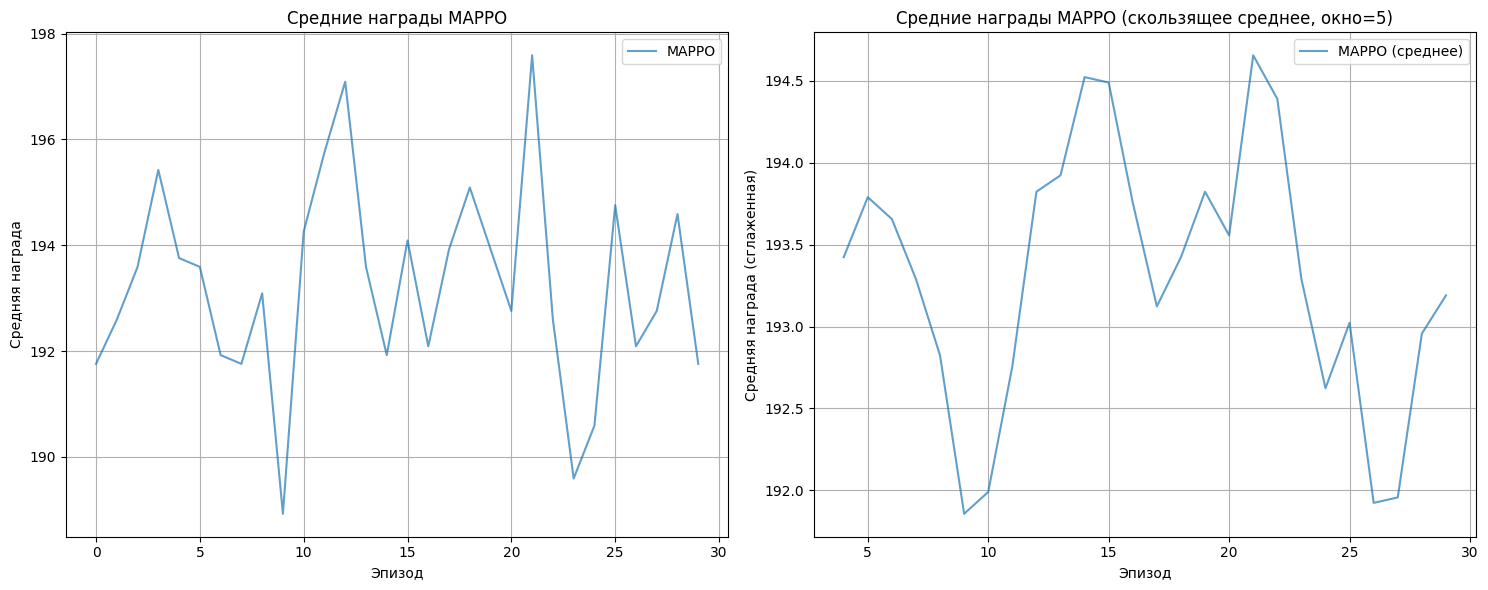


=== ИТОГОВАЯ СВОДКА ДЛЯ MAPPO ===
Средняя награда по всем эпизодам: 193.24
Общее количество кризисов: 4293
Общее количество переходов между стадиями: 600

Топ-5 типов кризисов по частоте:
  Финансовый крах: 564 раз
  Социальные волнения: 563 раз
  Политический переворот: 551 раз
  Технологическая катастрофа: 549 раз
  Пандемия: 539 раз


In [4]:
# =============================================================================
# БЛОК 2: ЭКСПЕРИМЕНТ С MAPPO (30 ЭПОХ)
# =============================================================================

import time
import random
import numpy as np
import pandas as pd
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
import json
import requests
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal
import torch.multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter

CONFIG = {
    'start_year': 2017,
    'train_end_year': 2024,
    'sim_start_year': 2025,
    'sim_end_year': 2075,
    'steps_per_year': 12,
    'num_episodes': 30,  # Изменено на 30
    'top_countries': 20,
    'observation_total_size': 12,
    'observation_in_size': 12,
    'action_size': 45,
    'hidden_dim': 256,
    'lr_actor': 1e-4,
    'lr_critic': 1e-3,
    'gamma': 0.99,
    'tau': 0.01,
    'buffer_size': int(1e6),
    'batch_size': 256,
    'update_every': 10,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,
    'clip_epsilon': 0.2,
    'gae_lambda': 0.95,
    'ppo_epochs': 4,
    'entropy_coef': 0.01,
    'max_grad_norm': 0.5,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_dir': 'experiment_results_mappo',
    'data_dir': 'data'
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['data_dir'], exist_ok=True)

def fetch_world_bank_data(indicator, country_code, start_year, end_year):
    base_url = "http://api.worldbank.org/v2/country"
    url = f"{base_url}/{country_code}/indicator/{indicator}?date={start_year}:{end_year}&format=json&per_page=100"

    try:
        response = requests.get(url)
        data = response.json()
        if len(data) > 1:
            return {item['date']: item['value'] for item in data[1] if item['value'] is not None}
        else:
            return {}
    except Exception as e:
        print(f"Ошибка при загрузке данных для {country_code}, {indicator}: {e}")
        return {}

def load_real_historical_data():
    print("Загрузка реальных исторических данных...")

    countries = {
        "United States": "US", "China": "CN", "Japan": "JP", "Germany": "DE", "India": "IN",
        "United Kingdom": "GB", "France": "FR", "Italy": "IT", "Brazil": "BR", "Canada": "CA",
        "South Korea": "KR", "Russia": "RU", "Australia": "AU", "Spain": "ES", "Mexico": "MX",
        "Indonesia": "ID", "Netherlands": "NL", "Saudi Arabia": "SA", "Turkey": "TR", "Switzerland": "CH"
    }

    indicators = {
        'gdp_growth': 'NY.GDP.MKTP.KD.ZG', 'unemployment': 'SL.UEM.TOTL.ZS', 'inflation': 'FP.CPI.TOTL.ZG',
        'aging_index': 'SP.POP.65UP.TO.ZS', 'migration_net': 'SM.POP.NETM', 'gini_coefficient': 'SI.POV.GINI',
        'corruption_index': 'CC.EST', 'political_stability': 'PV.EST', 'innovation_index': 'GB.XPD.RSDV.GD.ZS',
        'environmental_footprint': 'EN.ATM.CO2E.PC', 'education_index': 'SE.TER.ENRR', 'press_freedom': 'EN.PUB.FREX'
    }

    data = {}

    for country_name, country_code in countries.items():
        print(f"Загрузка данных для {country_name}...")
        country_data = {}

        for indicator_name, indicator_code in indicators.items():
            indicator_data = fetch_world_bank_data(indicator_code, country_code, CONFIG['start_year'], CONFIG['train_end_year'])
            country_data[indicator_name] = indicator_data

        years = list(range(CONFIG['start_year'], CONFIG['train_end_year'] + 1))
        country_array = []

        for year in years:
            year_str = str(year)
            row = []
            for indicator_name in indicators.keys():
                value = country_data[indicator_name].get(year_str, np.nan)
                row.append(value if value is not None else np.nan)
            country_array.append(row)

        country_array = np.array(country_array)
        if len(country_array) > 0:
            df = pd.DataFrame(country_array, columns=list(indicators.keys()))
            df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
            data[country_name] = df.values
        else:
            data[country_name] = np.zeros((CONFIG['train_end_year'] - CONFIG['start_year'] + 1, len(indicators)))

    print("Реальные данные успешно загружены.")
    return data, list(countries.keys())

def generate_synthetic_data(historical_data, countries):
    print("Генерация синтетических данных...")
    synthetic_data = {}

    for country in countries:
        if country in historical_data and len(historical_data[country]) > 0:
            last_data = historical_data[country][-1]
        else:
            last_data = np.random.randn(CONFIG['observation_total_size']) * 0.1

        sim_years = CONFIG['sim_end_year'] - CONFIG['sim_start_year'] + 1
        country_data = []

        for _ in range(sim_years):
            noise = np.random.randn(len(last_data)) * 0.01
            new_data = last_data + noise
            country_data.append(new_data)
            last_data = new_data

        synthetic_data[country] = np.array(country_data)

    print("Синтетические данные сгенерированы.")
    return synthetic_data

def load_historical_data():
    try:
        real_data, countries = load_real_historical_data()
    except Exception as e:
        print(f"Не удалось загрузить реальные данные: {e}")
        print("Использование синтетических данных...")
        countries = [
            "United States", "China", "Japan", "Germany", "India", "United Kingdom",
            "France", "Italy", "Brazil", "Canada", "South Korea", "Russia", "Australia",
            "Spain", "Mexico", "Indonesia", "Netherlands", "Saudi Arabia", "Turkey", "Switzerland"
        ]

        np.random.seed(42)
        real_data = {}

        for country in countries:
            years = CONFIG['train_end_year'] - CONFIG['start_year'] + 1
            country_data = np.random.randn(years, CONFIG['observation_total_size']) * 0.1
            real_data[country] = country_data

    synthetic_data = generate_synthetic_data(real_data, countries)
    return real_data, synthetic_data, countries

class CountrySystem:
    def __init__(self, name, initial_state):
        self.name = name
        self.state = initial_state.copy()
        self.internal_state = self._initialize_internal_state()
        self.stage = "I. Конструктивная адаптация"
        self.history = []
        self.crisis_history = []
        self.stage_transitions = []
        self.step_count = 0
        self.year = CONFIG['sim_start_year']
        self.month = 1

    def _initialize_internal_state(self):
        return np.array([
            0.8, 1.0, 0.7, 0.75, 0.6, 0.5, 0.2, 0.8, 0.3, 0.5, 0.7, 0.6
        ])

    def get_observation_total(self):
        return self.state

    def get_observation_in(self):
        return self.internal_state

    def apply_action(self, action):
        reward = 0
        crisis_event = None

        self._update_internal_state(action)
        self._update_external_state(action)

        crisis_event = self._check_for_crisis()
        if crisis_event:
            self.crisis_history.append({
                'step': self.step_count, 'year': self.year, 'month': self.month, 'crisis': crisis_event
            })
            reward -= 100

        new_stage = self._check_stage_transition()
        if new_stage != self.stage:
            self.stage_transitions.append({
                'step': self.step_count, 'year': self.year, 'month': self.month,
                'from_stage': self.stage, 'to_stage': new_stage
            })
            self.stage = new_stage
            reward += self._get_stage_reward(new_stage)

        reward += self._calculate_stability_reward()

        self.step_count += 1
        self.month += 1
        if self.month > 12:
            self.month = 1
            self.year += 1

        self.history.append({
            'step': self.step_count, 'state': self.state.copy(), 'internal_state': self.internal_state.copy(),
            'stage': self.stage, 'year': self.year, 'month': self.month
        })

        return reward, crisis_event is not None

    def _update_internal_state(self, action):
        action_effects = np.zeros_like(self.internal_state)

        if action == 0:  # Повышение налогов
            action_effects[0] -= 0.03; action_effects[2] -= 0.01; action_effects[9] -= 0.02
        elif action == 1:  # Снижение налогов
            action_effects[0] += 0.02; action_effects[2] += 0.01; action_effects[9] += 0.03
        elif action == 2:  # Увеличение социальных расходов
            action_effects[4] += 0.04; action_effects[10] += 0.03; action_effects[9] += 0.02
        elif action == 3:  # Сокращение социальных расходов
            action_effects[4] -= 0.03; action_effects[10] -= 0.02; action_effects[9] -= 0.01
        elif action == 4:  # Реформа пенсионной системы
            action_effects[4] += 0.02; action_effects[1] += 0.03
        elif action == 5:  # Реформа здравоохранения
            action_effects[0] += 0.02; action_effects[10] += 0.02
        elif action == 6:  # Инвестиции в образование и науку
            action_effects[5] += 0.04; action_effects[7] += 0.03
        elif action == 7:  # Поддержка инноваций и стартапов
            action_effects[5] += 0.05; action_effects[11] += 0.04
        elif action == 8:  # Ужесточение миграционной политики
            action_effects[4] -= 0.02; action_effects[10] -= 0.01
        elif action == 9:  # Либерализация миграционной политики
            action_effects[4] += 0.03; action_effects[10] += 0.02
        elif action == 10: # Проведение амнистии для мигрантов
            action_effects[4] += 0.02; action_effects[10] += 0.03
        elif action == 11: # Усиление полицейского контроля
            action_effects[0] -= 0.02; action_effects[9] -= 0.03
        elif action == 12: # Снижение репрессий, декриминализация
            action_effects[0] += 0.03; action_effects[9] += 0.02
        elif action == 13: # Проведение выборов (честных, свободных)
            action_effects[0] += 0.05; action_effects[7] += 0.04
        elif action == 14: # Фальсификация выборов
            action_effects[0] -= 0.04; action_effects[7] -= 0.03
        elif action == 15: # Роспуск парламента
            action_effects[0] -= 0.03; action_effects[8] += 0.04
        elif action == 16: # Распуск оппозиционных партий
            action_effects[0] -= 0.04; action_effects[7] -= 0.03
        elif action == 17: # Преследование оппозиционеров
            action_effects[0] -= 0.03; action_effects[8] += 0.03
        elif action == 18: # Амнистия политзаключенных
            action_effects[0] += 0.02; action_effects[10] += 0.02
        elif action == 19: # Реформа судебной системы
            action_effects[0] += 0.03; action_effects[11] += 0.02
        elif action == 20: # Укрепление независимости судов
            action_effects[0] += 0.04; action_effects[7] += 0.03
        elif action == 21: # Подавление свободы слова
            action_effects[0] -= 0.04; action_effects[7] -= 0.03
        elif action == 22: # Поддержка свободы слова
            action_effects[0] += 0.04; action_effects[7] += 0.03
        elif action == 23: # Введение цензуры
            action_effects[0] -= 0.03; action_effects[8] += 0.03
        elif action == 24: # Поддержка СМИ
            action_effects[0] += 0.03; action_effects[7] += 0.02
        elif action == 25: # Проведение референдума
            action_effects[0] += 0.02; action_effects[7] += 0.02
        elif action == 26: # Реформа конституции
            action_effects[11] += 0.04; action_effects[5] -= 0.02
        elif action == 27: # Увеличение числа чиновников
            action_effects[1] -= 0.02; action_effects[8] += 0.02
        elif action == 28: # Сокращение бюрократии
            action_effects[1] += 0.03; action_effects[11] += 0.02
        elif action == 29: # Борьба с коррупцией (эффективная)
            action_effects[0] += 0.04; action_effects[10] += 0.03
        elif action == 30: # Имитация борьбы с коррупцией
            action_effects[0] -= 0.02; action_effects[10] -= 0.01
        elif action == 31: # Заключение торгового соглашения
            action_effects[3] += 0.02; action_effects[11] += 0.02
        elif action == 32: # Введение торговых пошлин/санкций
            action_effects[3] -= 0.02; action_effects[9] -= 0.02
        elif action == 33: # Поддержка экспорта
            action_effects[3] += 0.03; action_effects[11] += 0.02
        elif action == 34: # Поддержка импорта
            action_effects[3] += 0.02; action_effects[5] -= 0.01
        elif action == 35: # Заключение военного альянса
            action_effects[9] -= 0.03; action_effects[8] += 0.02
        elif action == 36: # Выход из военного альянса
            action_effects[9] += 0.02; action_effects[11] += 0.01
        elif action == 37: # Начало переговоров
            action_effects[0] += 0.02; action_effects[3] += 0.02
        elif action == 38: # Прекращение переговоров
            action_effects[0] -= 0.01; action_effects[3] -= 0.01
        elif action == 39: # Ведение войны (наступательной)
            action_effects[9] -= 0.05; action_effects[8] += 0.04
        elif action == 40: # Ведение войны (оборонительной)
            action_effects[9] -= 0.03; action_effects[10] -= 0.02
        elif action == 41: # Отправка миротворцев
            action_effects[0] += 0.02; action_effects[3] += 0.02
        elif action == 42: # Принятие беженцев
            action_effects[4] += 0.03; action_effects[10] += 0.02
        elif action == 43: # Отказ от беженцев
            action_effects[4] -= 0.02; action_effects[10] -= 0.01
        elif action == 44: # Мирная экспансия
            action_effects[5] += 0.03; action_effects[11] += 0.03

        self.internal_state = np.clip(self.internal_state + action_effects, 0.0, 1.0)

    def _update_external_state(self, action):
        noise = np.random.normal(0, 0.01, len(self.state))
        self.state = self.state + noise

        if action == 0:
            self.state[0] -= 0.1; self.state[1] += 0.2
        elif action == 2:
            self.state[4] += 0.1; self.state[6] -= 0.05
        elif action == 6:
            self.state[8] += 0.03
        elif action == 7:
            self.state[8] += 0.05
        elif action == 39:
            self.state[0] -= 0.3; self.state[1] += 0.5; self.state[2] += 0.3

    def _check_for_crisis(self):
        crisis_probability = 0.0

        if self.internal_state[4] < 0.3 and self.state[5] > 0.7:
            crisis_probability += 0.1
        if self.state[4] > 1.0 and self.internal_state[10] < 0.4:
            crisis_probability += 0.15
        if self.internal_state[0] < 0.3 and self.internal_state[2] < 0.4:
            crisis_probability += 0.2
        if self.state[0] < -2.0 or self.state[1] > 15.0:
            crisis_probability += 0.25

        if np.random.random() < crisis_probability:
            crises = ["Политический переворот", "Экономический кризис", "Социальные волнения",
                     "Военный конфликт", "Экологическая катастрофа", "Финансовый крах",
                     "Пандемия", "Технологическая катастрофа"]
            return np.random.choice(crises)

        return None

    def _check_stage_transition(self):
        if (self.internal_state[0] > 0.8 and self.internal_state[2] > 0.8 and
            self.internal_state[10] > 0.8 and self.internal_state[4] > 0.7):
            return "Точка Превосходства"

        elif (self.internal_state[5] > 0.7 and self.internal_state[7] < 0.3 and
              self.internal_state[1] < 0.4):
            return "Точка Плато (Застой)"

        elif (self.internal_state[6] > 0.8 and self.internal_state[9] < 0.2 and
              self.internal_state[8] > 0.7):
            return "Точка Перенапряжения"

        elif (self.internal_state[10] < 0.2 and self.internal_state[0] < 0.2 and
              self.internal_state[7] < 0.1):
            return "Точка Гибели/Перезапуска"

        if self.internal_state[5] > 0.6 and self.internal_state[7] < 0.4:
            return "III. Деструктивная экспансия"
        elif self.internal_state[5] < 0.4 and self.internal_state[7] > 0.6:
            return "I. Конструктивная адаптация"
        elif self.internal_state[5] > 0.5 and self.internal_state[7] > 0.5:
            return "II. Конструктивная экспансия"
        else:
            return "IV. Деструктивная адаптация (кризис)"

    def _get_stage_reward(self, stage):
        rewards = {
            "Точка Превосходства": 100, "I. Конструктивная адаптация": 50,
            "II. Конструктивная экспансия": 50, "Точка Плато (Застой)": -10,
            "III. Деструктивная экспансия": -50, "Точка Перенапряжения": -100,
            "IV. Деструктивная адаптация (кризис)": -200, "Точка Гибели/Перезапуска": -1000
        }
        return rewards.get(stage, 0)

    def _calculate_stability_reward(self):
        stability_reward = 0
        balance = abs(self.internal_state[5] - 0.5)
        stability_reward += (1 - balance) * 10
        stability_reward += self.internal_state[0] * 5
        stability_reward -= self.internal_state[6] * 10
        stability_reward += self.internal_state[4] * 3
        stability_reward -= self.internal_state[8] * 5
        return stability_reward

class MAPPOActor(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=CONFIG['hidden_dim']):
        super(MAPPOActor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        return self.net(obs)

class MAPPOCritic(nn.Module):
    def __init__(self, obs_dim, num_agents, hidden_dim=CONFIG['hidden_dim']):
        super(MAPPOCritic, self).__init__()
        self.num_agents = num_agents
        # Исправлено: общее количество наблюдений для всех агентов
        total_obs_dim = obs_dim * num_agents

        self.net = nn.Sequential(
            nn.Linear(total_obs_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs):
        # Исправлено: правильная обработка входных данных
        if isinstance(obs, list):
            # Если список тензоров, объединяем их
            obs_flat = torch.cat(obs, dim=-1)
        elif isinstance(obs, torch.Tensor):
            # Если уже тензор, используем его напрямую
            obs_flat = obs
        else:
            # Если numpy массив, преобразуем в тензор
            obs_flat = torch.FloatTensor(obs).to(CONFIG['device'])
            if len(obs_flat.shape) == 1:
                obs_flat = obs_flat.unsqueeze(0)

        return self.net(obs_flat)

class MAPPOAgent:
    def __init__(self, obs_total_dim, obs_in_dim, action_dim, agent_id, num_agents):
        self.agent_id = agent_id
        self.action_dim = action_dim
        # Исправлено: общая размерность наблюдений для одного агента
        self.obs_dim = obs_total_dim + obs_in_dim
        self.num_agents = num_agents

        self.actor = MAPPOActor(self.obs_dim, action_dim).to(CONFIG['device'])
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=CONFIG['lr_actor'])

        # Исправлено: передаем правильную размерность в критик
        self.critic = MAPPOCritic(self.obs_dim, num_agents).to(CONFIG['device'])
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CONFIG['lr_critic'])

        self.trajectories = []
        # Сохраняем последние наблюдения всех агентов для критика
        self.last_observations = None

    def act(self, obs_total, obs_in, all_observations_total=None, all_observations_in=None):
        # Исправлено: правильное формирование входного тензора
        obs = torch.FloatTensor(np.concatenate([obs_total, obs_in])).unsqueeze(0).to(CONFIG['device'])
        action_probs = self.actor(obs)
        dist = Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)

        # Сохраняем все наблюдения для последующего использования в критике
        if all_observations_total is not None and all_observations_in is not None:
            self.last_observations = (all_observations_total, all_observations_in)

        # Для value используем отдельную оценку
        value = 0.0  # Заглушка, будет вычислено позже

        return action.item(), log_prob.item(), value, action_probs.detach().cpu().numpy()

    def store_trajectory(self, transition):
        self.trajectories.append(transition)

    def compute_returns_and_advantages(self, rewards, values, dones):
        returns = []
        gae = 0
        values = list(values) + [0]

        for i in reversed(range(len(rewards))):
            if dones[i]:
                delta = rewards[i] - values[i]
                gae = delta
            else:
                delta = rewards[i] + CONFIG['gamma'] * values[i+1] - values[i]
                gae = delta + CONFIG['gamma'] * CONFIG['gae_lambda'] * gae

            returns.insert(0, gae + values[i])

        advantages = [returns[i] - values[i] for i in range(len(returns))]
        return returns, advantages

    def update(self, agents, all_observations_total_list, all_observations_in_list):
        if len(self.trajectories) == 0:
            return

        # Извлечение данных из траекторий
        states, actions, log_probs_old, values_old, rewards, dones = zip(*self.trajectories)

        # Преобразование в тензоры
        states_tensor = torch.FloatTensor(np.array(states)).to(CONFIG['device'])
        actions_tensor = torch.LongTensor(actions).to(CONFIG['device'])
        log_probs_old_tensor = torch.FloatTensor(log_probs_old).to(CONFIG['device'])
        values_old_tensor = torch.FloatTensor(values_old).to(CONFIG['device'])
        rewards_tensor = torch.FloatTensor(rewards).to(CONFIG['device'])
        dones_tensor = torch.BoolTensor(dones).to(CONFIG['device'])

        # Вычисление возвращений и преимуществ
        returns, advantages = self.compute_returns_and_advantages(
            rewards_tensor.cpu().numpy(),
            values_old_tensor.cpu().numpy(),
            dones_tensor.cpu().numpy()
        )
        returns_tensor = torch.FloatTensor(returns).to(CONFIG['device'])
        advantages_tensor = torch.FloatTensor(advantages).to(CONFIG['device'])

        # Нормализация преимуществ
        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

        # Обновление несколько раз (PPO epochs)
        for _ in range(CONFIG['ppo_epochs']):
            # Обновление критика
            # Формируем тензор всех наблюдений для критика
            all_obs_list = []
            for i in range(len(all_observations_total_list)):
                obs_total = all_observations_total_list[i]
                obs_in = all_observations_in_list[i]
                obs_combined = np.concatenate([obs_total, obs_in])
                all_obs_list.append(torch.FloatTensor(obs_combined).unsqueeze(0).to(CONFIG['device']))

            # Исправлено: правильный формат для критика
            values = self.critic(all_obs_list).squeeze(-1)
            critic_loss = F.mse_loss(values, returns_tensor[:len(values)])  # Обрезаем, если нужно

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), CONFIG['max_grad_norm'])
            self.critic_optimizer.step()

            # Обновление актера
            action_probs = self.actor(states_tensor)
            dist = Categorical(action_probs)
            log_probs_new = dist.log_prob(actions_tensor)

            ratio = torch.exp(log_probs_new - log_probs_old_tensor)
            surr1 = ratio * advantages_tensor[:len(ratio)]  # Обрезаем, если нужно
            surr2 = torch.clamp(ratio, 1 - CONFIG['clip_epsilon'], 1 + CONFIG['clip_epsilon']) * advantages_tensor[:len(ratio)]
            actor_loss = -torch.min(surr1, surr2).mean()

            # Добавление регуляризации энтропии
            entropy = dist.entropy().mean()
            actor_loss -= CONFIG['entropy_coef'] * entropy

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), CONFIG['max_grad_norm'])
            self.actor_optimizer.step()

        # Очистка траекторий
        self.trajectories = []

def run_mappo_experiment():
    print("Запуск эксперимента с MAPPO агентами...")

    real_data, synthetic_data, countries = load_historical_data()

    country_systems = {}
    for country in countries:
        if country in real_data and len(real_data[country]) > 0:
            initial_state = real_data[country][-1]
        else:
            initial_state = synthetic_data[country][0] if len(synthetic_data[country]) > 0 else np.zeros(CONFIG['observation_total_size'])
        country_systems[country] = CountrySystem(country, initial_state)

    agents = {}
    obs_total_dim = CONFIG['observation_total_size']
    obs_in_dim = CONFIG['observation_in_size']
    action_dim = CONFIG['action_size']
    num_agents = len(countries)

    for i, country in enumerate(countries):
        agents[country] = MAPPOAgent(obs_total_dim, obs_in_dim, action_dim, i, num_agents)

    all_rewards = []
    all_crisis_histories = {country: [] for country in countries}
    all_stage_transitions = {country: [] for country in countries}
    final_states = {}

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(f'runs/MAPPO_experiment_{timestamp}')

    experiment_start_time = time.time()

    for episode in range(CONFIG['num_episodes']):
        episode_start_time = time.time()
        print(f"Эпизод {episode + 1}/{CONFIG['num_episodes']}")

        for country in countries:
            if country in real_data and len(real_data[country]) > 0:
                initial_state = real_data[country][-1]
            else:
                initial_state = synthetic_data[country][0] if len(synthetic_data[country]) > 0 else np.zeros(CONFIG['observation_total_size'])
            country_systems[country] = CountrySystem(country, initial_state)

        for agent in agents.values():
            agent.trajectories = []

        episode_rewards = []
        episode_crisis_count = 0

        total_steps = (CONFIG['sim_end_year'] - CONFIG['sim_start_year']) * CONFIG['steps_per_year']
        episode_step_start_time = time.time()

        for step in range(total_steps):
            observations_total = []
            observations_in = []
            actions = []

            for country in countries:
                obs_total = country_systems[country].get_observation_total()
                obs_in = country_systems[country].get_observation_in()
                observations_total.append(obs_total)
                observations_in.append(obs_in)

            for country in countries:
                action, log_prob, value, action_probs = agents[country].act(
                    observations_total[countries.index(country)],
                    observations_in[countries.index(country)],
                    observations_total,  # Передаем все наблюдения
                    observations_in      # Передаем все внутренние наблюдения
                )
                actions.append(action)

            rewards = []
            for i, country in enumerate(countries):
                reward, crisis_occurred = country_systems[country].apply_action(actions[i])
                rewards.append(reward)
                if crisis_occurred:
                    episode_crisis_count += 1

            episode_rewards.append(sum(rewards))

            for i, country in enumerate(countries):
                transition = (
                    np.concatenate([observations_total[i], observations_in[i]]),
                    actions[i],
                    0,
                    0,
                    rewards[i],
                    step == total_steps - 1
                )
                agents[country].store_trajectory(transition)

            if step > 0 and step % (total_steps // 10) == 0:
                elapsed_step_time = time.time() - episode_step_start_time
                steps_remaining = total_steps - step
                estimated_time_remaining = (elapsed_step_time / step) * steps_remaining if step > 0 else 0
                print(f"  Шаг {step}/{total_steps} ({step/total_steps*100:.1f}%) | "
                      f"Прошло: {timedelta(seconds=int(elapsed_step_time))} | "
                      f"Осталось: {timedelta(seconds=int(estimated_time_remaining))}")

        # Собираем все наблюдения для обновления
        all_observations_total_list = []
        all_observations_in_list = []
        for country in countries:
            obs_total = country_systems[country].get_observation_total()
            obs_in = country_systems[country].get_observation_in()
            all_observations_total_list.append(obs_total)
            all_observations_in_list.append(obs_in)

        for country in countries:
            agents[country].update(list(agents.values()), all_observations_total_list, all_observations_in_list)

        avg_reward = np.mean(episode_rewards)
        all_rewards.append(avg_reward)

        for country in countries:
            all_crisis_histories[country].extend(country_systems[country].crisis_history)
            all_stage_transitions[country].extend(country_systems[country].stage_transitions)

        writer.add_scalar('Average Reward', avg_reward, episode)
        writer.add_scalar('Crisis Count', episode_crisis_count, episode)

        episode_elapsed_time = time.time() - episode_start_time
        episodes_remaining = CONFIG['num_episodes'] - episode - 1
        experiment_elapsed_time = time.time() - experiment_start_time
        estimated_total_experiment_time = (experiment_elapsed_time / (episode + 1)) * CONFIG['num_episodes']
        estimated_experiment_remaining = estimated_total_experiment_time - experiment_elapsed_time

        print(f"  Средняя награда: {avg_reward:.2f}, Кризисов: {episode_crisis_count}")
        print(f"  Время эпизода: {timedelta(seconds=int(episode_elapsed_time))}")
        print(f"  Прошло эксперимента: {timedelta(seconds=int(experiment_elapsed_time))} | "
              f"Осталось: {timedelta(seconds=int(estimated_experiment_remaining))}")

    for country in countries:
        final_states[country] = country_systems[country].state

    writer.close()

    results = {
        'final_states': final_states,
        'all_rewards': all_rewards,
        'all_crisis_histories': all_crisis_histories,
        'all_stage_transitions': all_stage_transitions,
        'countries': countries
    }

    with open(f"{CONFIG['save_dir']}/MAPPO_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    experiment_total_time = time.time() - experiment_start_time
    print(f"Эксперимент с MAPPO завершен.")
    print(f"Общее время эксперимента: {timedelta(seconds=int(experiment_total_time))}")
    return results

def plot_mappo_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(results['all_rewards'], label='MAPPO', alpha=0.7)
    ax1.set_xlabel('Эпизод')
    ax1.set_ylabel('Средняя награда')
    ax1.set_title('Средние награды MAPPO')
    ax1.legend()
    ax1.grid(True)

    window_size = 5
    rewards_smooth = pd.Series(results['all_rewards']).rolling(window=window_size).mean()
    ax2.plot(rewards_smooth, label='MAPPO (среднее)', alpha=0.7)
    ax2.set_xlabel('Эпизод')
    ax2.set_ylabel('Средняя награда (сглаженная)')
    ax2.set_title(f'Средние награды MAPPO (скользящее среднее, окно={window_size})')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{CONFIG['save_dir']}/MAPPO_reward_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_mappo_summary(results):
    print("\n=== ИТОГОВАЯ СВОДКА ДЛЯ MAPPO ===")

    avg_reward = np.mean(results['all_rewards'])
    print(f"Средняя награда по всем эпизодам: {avg_reward:.2f}")

    total_crises = sum(len(crises) for crises in results['all_crisis_histories'].values())
    print(f"Общее количество кризисов: {total_crises}")

    total_transitions = sum(len(transitions) for transitions in results['all_stage_transitions'].values())
    print(f"Общее количество переходов между стадиями: {total_transitions}")

    crisis_types = []
    for crises in results['all_crisis_histories'].values():
        for crisis in crises:
            crisis_types.append(crisis['crisis'])

    if crisis_types:
        from collections import Counter
        crisis_counter = Counter(crisis_types)
        print("\nТоп-5 типов кризисов по частоте:")
        for crisis, count in crisis_counter.most_common(5):
            print(f"  {crisis}: {count} раз")

    with open(f"{CONFIG['save_dir']}/MAPPO_detailed_summary.txt", 'w', encoding='utf-8') as f:
        f.write("ИТОГОВАЯ СВОДКА ДЛЯ MAPPO\n")
        f.write("=" * 50 + "\n")
        f.write(f"Средняя награда по всем эпизодам: {avg_reward:.2f}\n")
        f.write(f"Общее количество кризисов: {total_crises}\n")
        f.write(f"Общее количество переходов между стадиями: {total_transitions}\n\n")

        f.write("История кризисов по странам:\n")
        for country, crises in results['all_crisis_histories'].items():
            if crises:
                f.write(f"\n{country}:\n")
                for crisis in crises:
                    f.write(f"  Год {crisis['year']}, Месяц {crisis['month']}: {crisis['crisis']}\n")

        f.write("\n\nИстория переходов между стадиями по странам:\n")
        for country, transitions in results['all_stage_transitions'].items():
            if transitions:
                f.write(f"\n{country}:\n")
                for transition in transitions:
                    f.write(f"  Год {transition['year']}, Месяц {transition['month']}: "
                           f"{transition['from_stage']} -> {transition['to_stage']}\n")

def prevent_runtime_disconnect():
    print("Для предотвращения отключения среды введите '555' и нажмите Enter:")
    while True:
        user_input = input()
        if user_input == "555":
            print("Среда защищена от отключения.")
            break
        else:
            print("Неверный код. Пожалуйста, введите '555':")

if __name__ == "__main__":
    prevent_runtime_disconnect()
    print("\n" + "=" * 50)
    print("ЗАПУСК MAPPO ЭКСПЕРИМЕНТА (30 ЭПОХ)")
    print("=" * 50)
    mappo_results = run_mappo_experiment()
    plot_mappo_results(mappo_results)
    print_mappo_summary(mappo_results)

Для предотвращения отключения среды введите '555' и нажмите Enter:
555
Среда защищена от отключения.
ЗАГРУЗКА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ
Результаты MADDPG успешно загружены.
Результаты MAPPO успешно загружены.

СРАВНЕНИЕ РЕЗУЛЬТАТОВ


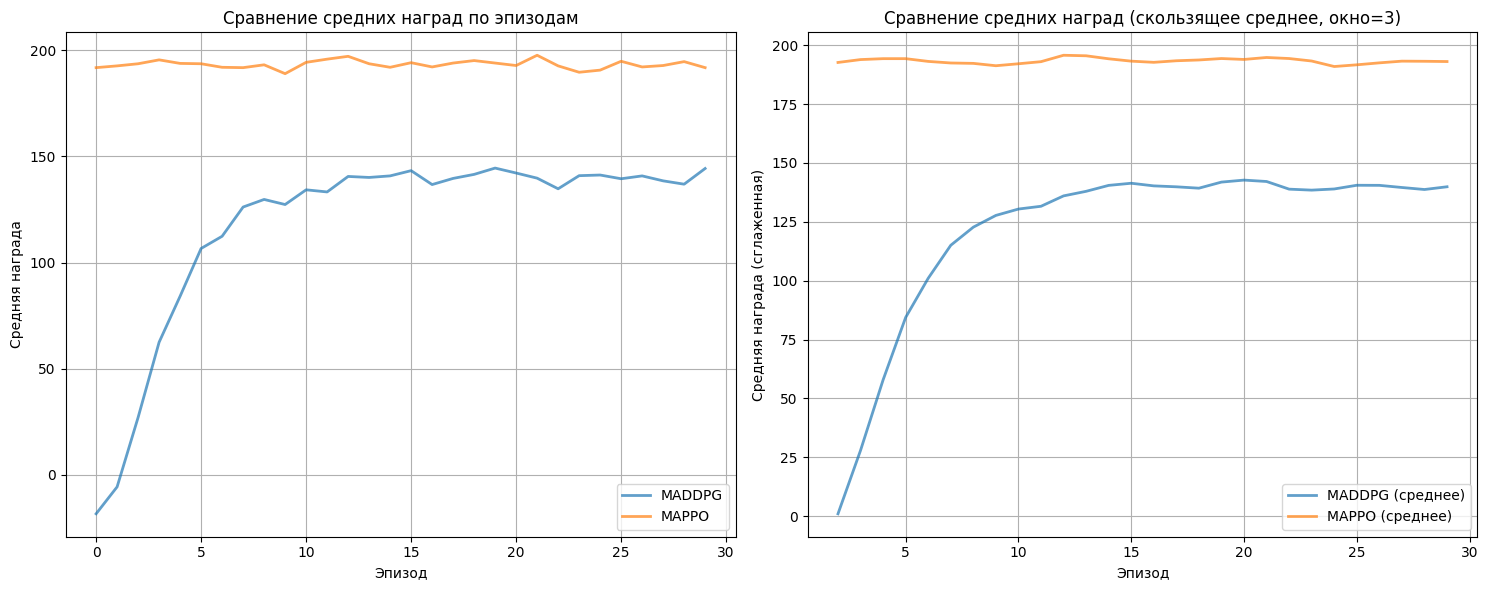


=== СРАВНЕНИЕ НАГРАД ===
MADDPG - Средняя награда: 118.16 ± 43.35
MAPPO - Средняя награда: 193.24 ± 1.90
Разница: 75.08

=== СРАВНЕНИЕ КРИЗИСОВ ===
Общее количество кризисов MADDPG: 13276
Общее количество кризисов MAPPO: 4293

Топ-5 типов кризисов MADDPG:
  Военный конфликт: 1694 раз
  Экологическая катастрофа: 1680 раз
  Экономический кризис: 1679 раз
  Финансовый крах: 1665 раз
  Политический переворот: 1645 раз

Топ-5 типов кризисов MAPPO:
  Финансовый крах: 564 раз
  Социальные волнения: 563 раз
  Политический переворот: 551 раз
  Технологическая катастрофа: 549 раз
  Пандемия: 539 раз

=== СРАВНЕНИЕ ПЕРЕХОДОВ МЕЖДУ СТАДИЯМИ ===
Общее количество переходов MADDPG: 1025
Общее количество переходов MAPPO: 600

=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ПО СТРАНАМ ===
        Страна  MADDPG кризисы  MAPPO кризисы  MADDPG переходы  MAPPO переходы
 United States              20              0               51              30
         China               0              0               48              30
 

In [5]:
# =============================================================================
# БЛОК 3: СРАВНЕНИЕ РЕЗУЛЬТАТОВ MADDPG И MAPPO
# =============================================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

CONFIG = {
    'maddpg_save_dir': 'experiment_results_maddpg',
    'mappo_save_dir': 'experiment_results_mappo',
    'comparison_dir': 'experiment_comparison',
    'device': 'cpu'  # Для загрузки результатов не нужен GPU
}

os.makedirs(CONFIG['comparison_dir'], exist_ok=True)

def load_results():
    """Загрузка результатов экспериментов"""
    try:
        with open(f"{CONFIG['maddpg_save_dir']}/MADDPG_results.pkl", 'rb') as f:
            maddpg_results = pickle.load(f)
        print("Результаты MADDPG успешно загружены.")
    except FileNotFoundError:
        print("Файл результатов MADDPG не найден.")
        maddpg_results = None

    try:
        with open(f"{CONFIG['mappo_save_dir']}/MAPPO_results.pkl", 'rb') as f:
            mappo_results = pickle.load(f)
        print("Результаты MAPPO успешно загружены.")
    except FileNotFoundError:
        print("Файл результатов MAPPO не найден.")
        mappo_results = None

    return maddpg_results, mappo_results

def compare_rewards(maddpg_results, mappo_results):
    """Сравнение наград"""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить награды: отсутствуют результаты одного или обоих экспериментов.")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График наград по эпизодам
    ax1.plot(maddpg_results['all_rewards'], label='MADDPG', alpha=0.7, linewidth=2)
    ax1.plot(mappo_results['all_rewards'], label='MAPPO', alpha=0.7, linewidth=2)
    ax1.set_xlabel('Эпизод')
    ax1.set_ylabel('Средняя награда')
    ax1.set_title('Сравнение средних наград по эпизодам')
    ax1.legend()
    ax1.grid(True)

    # Скользящее среднее
    window_size = 3
    maddpg_rewards_smooth = pd.Series(maddpg_results['all_rewards']).rolling(window=window_size).mean()
    mappo_rewards_smooth = pd.Series(mappo_results['all_rewards']).rolling(window=window_size).mean()

    ax2.plot(maddpg_rewards_smooth, label='MADDPG (среднее)', alpha=0.7, linewidth=2)
    ax2.plot(mappo_rewards_smooth, label='MAPPO (среднее)', alpha=0.7, linewidth=2)
    ax2.set_xlabel('Эпизод')
    ax2.set_ylabel('Средняя награда (сглаженная)')
    ax2.set_title(f'Сравнение средних наград (скользящее среднее, окно={window_size})')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f"{CONFIG['comparison_dir']}/reward_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Статистика
    maddpg_avg = np.mean(maddpg_results['all_rewards'])
    mappo_avg = np.mean(mappo_results['all_rewards'])
    maddpg_std = np.std(maddpg_results['all_rewards'])
    mappo_std = np.std(mappo_results['all_rewards'])

    print("\n=== СРАВНЕНИЕ НАГРАД ===")
    print(f"MADDPG - Средняя награда: {maddpg_avg:.2f} ± {maddpg_std:.2f}")
    print(f"MAPPO - Средняя награда: {mappo_avg:.2f} ± {mappo_std:.2f}")
    print(f"Разница: {mappo_avg - maddpg_avg:.2f}")

def compare_crises(maddpg_results, mappo_results):
    """Сравнение кризисов"""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить кризисы: отсутствуют результаты одного или обоих экспериментов.")
        return

    # Общее количество кризисов
    maddpg_total_crises = sum(len(crises) for crises in maddpg_results['all_crisis_histories'].values())
    mappo_total_crises = sum(len(crises) for crises in mappo_results['all_crisis_histories'].values())

    print("\n=== СРАВНЕНИЕ КРИЗИСОВ ===")
    print(f"Общее количество кризисов MADDPG: {maddpg_total_crises}")
    print(f"Общее количество кризисов MAPPO: {mappo_total_crises}")

    # Типы кризисов
    maddpg_crisis_types = []
    for crises in maddpg_results['all_crisis_histories'].values():
        for crisis in crises:
            maddpg_crisis_types.append(crisis['crisis'])

    mappo_crisis_types = []
    for crises in mappo_results['all_crisis_histories'].values():
        for crisis in crises:
            mappo_crisis_types.append(crisis['crisis'])

    from collections import Counter
    maddpg_counter = Counter(maddpg_crisis_types)
    mappo_counter = Counter(mappo_crisis_types)

    print("\nТоп-5 типов кризисов MADDPG:")
    for crisis, count in maddpg_counter.most_common(5):
        print(f"  {crisis}: {count} раз")

    print("\nТоп-5 типов кризисов MAPPO:")
    for crisis, count in mappo_counter.most_common(5):
        print(f"  {crisis}: {count} раз")

def compare_stage_transitions(maddpg_results, mappo_results):
    """Сравнение переходов между стадиями"""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить переходы: отсутствуют результаты одного или обоих экспериментов.")
        return

    maddpg_total_transitions = sum(len(transitions) for transitions in maddpg_results['all_stage_transitions'].values())
    mappo_total_transitions = sum(len(transitions) for transitions in mappo_results['all_stage_transitions'].values())

    print("\n=== СРАВНЕНИЕ ПЕРЕХОДОВ МЕЖДУ СТАДИЯМИ ===")
    print(f"Общее количество переходов MADDPG: {maddpg_total_transitions}")
    print(f"Общее количество переходов MAPPO: {mappo_total_transitions}")

def compare_countries(maddpg_results, mappo_results):
    """Сравнение результатов по странам"""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить страны: отсутствуют результаты одного или обоих экспериментов.")
        return

    countries = maddpg_results['countries'] if maddpg_results else mappo_results['countries']

    print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ПО СТРАНАМ ===")

    comparison_data = []

    for country in countries:
        maddpg_crises = len(maddpg_results['all_crisis_histories'][country]) if country in maddpg_results['all_crisis_histories'] else 0
        mappo_crises = len(mappo_results['all_crisis_histories'][country]) if country in mappo_results['all_crisis_histories'] else 0

        maddpg_transitions = len(maddpg_results['all_stage_transitions'][country]) if country in maddpg_results['all_stage_transitions'] else 0
        mappo_transitions = len(mappo_results['all_stage_transitions'][country]) if country in mappo_results['all_stage_transitions'] else 0

        comparison_data.append({
            'Страна': country,
            'MADDPG кризисы': maddpg_crises,
            'MAPPO кризисы': mappo_crises,
            'MADDPG переходы': maddpg_transitions,
            'MAPPO переходы': mappo_transitions
        })

    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))

    # Сохранение в файл
    df.to_csv(f"{CONFIG['comparison_dir']}/country_comparison.csv", index=False, encoding='utf-8')
    print(f"\nСравнение по странам сохранено в {CONFIG['comparison_dir']}/country_comparison.csv")

def create_summary_report(maddpg_results, mappo_results):
    """Создание сводного отчета"""
    with open(f"{CONFIG['comparison_dir']}/summary_report.txt", 'w', encoding='utf-8') as f:
        f.write("СВОДНЫЙ ОТЧЕТ СРАВНЕНИЯ MADDPG И MAPPO\n")
        f.write("=" * 50 + "\n")
        f.write(f"Дата создания отчета: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        if maddpg_results and mappo_results:
            maddpg_avg = np.mean(maddpg_results['all_rewards'])
            mappo_avg = np.mean(mappo_results['all_rewards'])
            maddpg_total_crises = sum(len(crises) for crises in maddpg_results['all_crisis_histories'].values())
            mappo_total_crises = sum(len(crises) for crises in mappo_results['all_crisis_histories'].values())
            maddpg_total_transitions = sum(len(transitions) for transitions in maddpg_results['all_stage_transitions'].values())
            mappo_total_transitions = sum(len(transitions) for transitions in mappo_results['all_stage_transitions'].values())

            f.write("ОСНОВНЫЕ ПОКАЗАТЕЛИ:\n")
            f.write(f"MADDPG - Средняя награда: {maddpg_avg:.2f}\n")
            f.write(f"MAPPO - Средняя награда: {mappo_avg:.2f}\n")
            f.write(f"MADDPG - Общее количество кризисов: {maddpg_total_crises}\n")
            f.write(f"MAPPO - Общее количество кризисов: {mappo_total_crises}\n")
            f.write(f"MADDPG - Общее количество переходов: {maddpg_total_transitions}\n")
            f.write(f"MAPPO - Общее количество переходов: {mappo_total_transitions}\n")

            winner = "MAPPO" if mappo_avg > maddpg_avg else "MADDPG" if maddpg_avg > mappo_avg else "Ничья"
            f.write(f"\nПОБЕДИТЕЛЬ ПО СРЕДНЕЙ НАГРАДЕ: {winner}\n")
        else:
            f.write("Недостаточно данных для сравнения.\n")

    print(f"\nСводный отчет сохранен в {CONFIG['comparison_dir']}/summary_report.txt")

def prevent_runtime_disconnect():
    print("Для предотвращения отключения среды введите '555' и нажмите Enter:")
    while True:
        user_input = input()
        if user_input == "555":
            print("Среда защищена от отключения.")
            break
        else:
            print("Неверный код. Пожалуйста, введите '555':")

def main():
    """Основная функция сравнения"""
    prevent_runtime_disconnect()

    print("ЗАГРУЗКА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ")
    print("=" * 50)

    maddpg_results, mappo_results = load_results()

    if maddpg_results is None and mappo_results is None:
        print("Нет результатов для сравнения.")
        return

    print("\nСРАВНЕНИЕ РЕЗУЛЬТАТОВ")
    print("=" * 50)

    # Сравнение наград
    compare_rewards(maddpg_results, mappo_results)

    # Сравнение кризисов
    compare_crises(maddpg_results, mappo_results)

    # Сравнение переходов
    compare_stage_transitions(maddpg_results, mappo_results)

    # Сравнение по странам
    compare_countries(maddpg_results, mappo_results)

    # Создание сводного отчета
    create_summary_report(maddpg_results, mappo_results)

    print(f"\nСРАВНЕНИЕ ЗАВЕРШЕНО!")
    print(f"Результаты сохранены в директории: {CONFIG['comparison_dir']}")

if __name__ == "__main__":
    main()